In [95]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as ttfu

def resection_with_2_known_points(point1, point2, measures_first_point, measures_second_point):
    station_z = ((point1[2] + (measures_first_point[2])*np.sin(measures_first_point[0])) + 
                 (point2[2] + (measures_second_point[2])*np.sin(measures_second_point[0])))/2
    # find the position of the total station using the intersection of 2 circles given by the measurements of the prism position.
    radius_1 = ((measures_first_point[2])*np.cos(measures_first_point[0]))
    radius_2 = ((measures_second_point[2])*np.cos(measures_second_point[0]))
    
    delta_x = point2[0] - point1[0]
    delta_y = point2[1] - point1[1]
    
    # find the y value based on the intersection of 2 circles aligned in x (same value of x)
    #x = (radius_1**2 - radius_2**2 - point1[0]**2 + point2[0]**2)/(2*delta_x)
    #y_1_1 = np.sqrt(radius_1**2 -(x - point1[0])**2)
    #y_2_1 = -np.sqrt(radius_1**2 -(x - point1[0])**2)
    #y_1_2 = np.sqrt(radius_2**2 -(x - point2[0])**2)
    #y_2_2 = -np.sqrt(radius_2**2 -(x - point2[0])**2)
    #station_pos_complete_1 = np.array([x, np.mean([y_1_1, y_1_2]), station_z, 0, 0, 0])   
    #station_pos_complete_2 = np.array([x, np.mean([y_2_1, y_2_2]), station_z, 0, 0, 0])
    
    # find the possible values of x based on the quadratic formula and the circle formula knowing y
    y = (radius_1**2 - radius_2**2 - point1[1]**2 + point2[1]**2)/(2*delta_y)
    x_1_1 = np.sqrt(radius_1**2 - (y - point1[1])**2)
    x_2_1 = -np.sqrt(radius_1**2 - (y - point1[1])**2)   
    x_1_2 = np.sqrt(radius_2**2 - (y - point2[1])**2)
    x_2_2 = -np.sqrt(radius_2**2 - (y - point2[1])**2)
    station_pos_complete_1 = np.array([np.mean([x_1_1, x_1_2]), y, station_z, 0, 0, 0])   
    station_pos_complete_2 = np.array([np.mean([x_2_1, x_2_2]), y, station_z, 0, 0, 0])
    
    return [station_pos_complete_1, station_pos_complete_2]

def calculate_tf_angle(point1, ref_point, station_pose):
    T = np.identity(4)
    dx1 = point1[0] - station_pose[0]
    dy1 = point1[1] - station_pose[1]
    dxref = ref_point[0] - station_pose[0]
    dyref = ref_point[1] - station_pose[1]
    if dyref >= 0:
        if dx1 <= 0:
            if dy1 >= 0:
                theta1 = np.arctan2(dy1, abs(dx1))
                theta2 = np.arctan2(dyref, dxref)
                thetaR = -(np.pi - theta1 - theta2)
            else:
                theta1 = np.arctan2(abs(dy1), abs(dx1))
                theta2 = np.arctan2(dyref, dxref)
                thetaR = -(np.pi + theta1 - theta2)
        else:
            if dy1 >= 0:
                theta1 = np.arctan2(dy1, dx1)
                theta2 = np.arctan2(dyref, dxref)
                thetaR = -(theta1 - theta2)
            else:
                theta1 = np.arctan2(abs(dy1), dx1)
                theta2 = np.arctan2(dyref, dxref)
                thetaR = -(theta2 + theta1)
    else:
        if dx1 <= 0:
            if dy1 >= 0:
                theta1 = np.arctan2(dy1, abs(dx1))
                theta2 = np.arctan2(abs(dyref), dxref)
                thetaR = (np.pi + theta1 - theta2)
            else:
                theta1 = np.arctan2(abs(dy1), abs(dx1))
                theta2 = np.arctan2(abs(dyref), dxref)
                thetaR = (np.pi - theta1 - theta2)
        else:
            if dy1 >= 0:
                theta1 = np.arctan2(dy1, dx1)
                theta2 = np.arctan2(abs(dyref), dxref)
                thetaR = -(theta1 + theta2)
            else:
                theta1 = np.arctan2(abs(dy1), dx1)
                theta2 = np.arctan2(abs(dyref), dxref)
                thetaR = -(theta2 - theta1)
    Rot_r = np.array([[np.cos(thetaR), -np.sin(thetaR), 0],
                 [np.sin(thetaR), np.cos(thetaR), 0],
                 [0, 0, 1]])
    T[0:3,0:3]=Rot_r
    return T

def calculate_tf_angle_using_scalar_product(measured_points, reference_points, calib_index):
    angle = 0
    if calib_index==0:
        measured_line = measured_points[0][:3] - measured_points[1][:3]
        reference_line = reference_points[0] - reference_points[1]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[0][0]<reference_points[0][0]:
            angle = -angle
    elif calib_index==1:
        measured_line = measured_points[0][:3] - measured_points[2][:3]
        reference_line = reference_points[0] - reference_points[2]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[0][0]>reference_points[0][0]:
            angle = -angle
    elif calib_index==2:
        measured_line = measured_points[0][:3] - measured_points[3][:3]
        reference_line = reference_points[0] - reference_points[3]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        print(measured_line)
        print(reference_line)
        print(angle)
        if measured_points[0][0]<reference_points[0][0]:
            angle = -angle
    elif calib_index==3:
        measured_line = measured_points[1][:3] - measured_points[2][:3]
        reference_line = reference_points[1] - reference_points[2]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[1][0]>reference_points[1][0]:
            angle = -angle
    elif calib_index==4:
        measured_line = measured_points[1][:3] - measured_points[3][:3]
        reference_line = reference_points[1] - reference_points[3]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[1][0]>reference_points[1][0]:
            angle = -angle
    elif calib_index==5:
        measured_line = measured_points[2][:3] - measured_points[3][:3]
        reference_line = reference_points[2] - reference_points[3]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[2][0]<reference_points[2][0]:
            angle = -angle
    T = np.identity(4)
    Rot_r = np.array([[np.cos(angle), -np.sin(angle), 0],
                 [np.sin(angle), np.cos(angle), 0],
                 [0, 0, 1]])
    T[0:3,0:3]=Rot_r
    print(T)
    return T

[[ 1.95496936e+01  1.38997754e+01  2.60693038e+00 -3.03949199e+00]
 [ 1.08622256e+01  2.60693038e+00 -1.38997754e+01 -2.21531273e+01]
 [-4.58707186e-09 -2.90060022e-09 -2.90060022e-09 -4.58625145e-09]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]


<IPython.core.display.Javascript object>


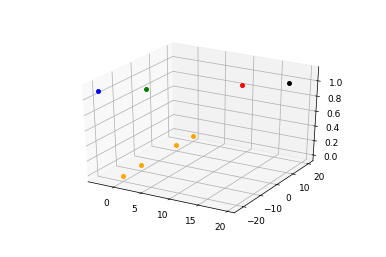

In [96]:
%matplotlib notebook

#pilier_A = np.array([0, 0, 0])
#pilier_B = np.array([0, np.sqrt(181.016**2 - 0.323**2), 0.323])
#pilier_C = np.array([0, np.sqrt(363.492**2 - 1.038**2), 1.038])
#pilier_D = np.array([0, np.sqrt(548.578**2 - 2.374**2), 2.374])

#pilier_A = np.array([0, 0, 0])
#pilier_B = np.array([np.sqrt(181.016**2 - 0.323**2), 0, 0.323])
#pilier_C = np.array([np.sqrt(363.492**2 - 1.038**2), 0, 1.038])
#pilier_D = np.array([np.sqrt(548.578**2 - 2.374**2), 0, 2.374])

pilier_A = np.array([0, 20, 0])
pilier_B = np.array([0, 10, 0])
pilier_C = np.array([0, -10, 0])
pilier_D = np.array([0, -20, 0])

liste_piliers = [pilier_A, pilier_B, pilier_C, pilier_D]

# Read markers file of grand axe and show them
tfu = importlib.reload(tfu)
ttfu = importlib.reload(ttfu)

file_name = './data/total_station/20220711/theodolite_reference_prisms_geomatic_fake2.txt'

raw_1, raw_2, raw_3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand = ttfu.read_marker_file_raw_data(file_name)

%matplotlib notebook
print(trimble_1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

Z_1 = 1.10116373
Z_2 = 0.80501063
Z_3 = 0.83504169
Z = Z_1

data_trimble = trimble_1

ax.scatter(data_trimble.T[0][0],data_trimble.T[0][1],data_trimble.T[0][2]+Z, color='black')
ax.scatter(data_trimble.T[1][0],data_trimble.T[1][1],data_trimble.T[1][2]+Z, color='r')
ax.scatter(data_trimble.T[2][0],data_trimble.T[2][1],data_trimble.T[2][2]+Z, color='g')
ax.scatter(data_trimble.T[3][0],data_trimble.T[3][1],data_trimble.T[3][2]+Z, color='b')

ax.scatter(pilier_A[0],pilier_A[1],pilier_A[2], color='orange')
ax.scatter(pilier_B[0],pilier_B[1],pilier_B[2], color='orange')
ax.scatter(pilier_C[0],pilier_C[1],pilier_C[2], color='orange')
ax.scatter(pilier_D[0],pilier_D[1],pilier_D[2], color='orange')


In [97]:
station_1_pos1 = []
station_1_pos2 = []
station_2_pos1 = []
station_2_pos2 = []
station_3_pos1 = []
station_3_pos2 = []

for i in range(len(liste_piliers)):
    for j in range(i+1, len(liste_piliers)):
        print(i,j)
        possible_poses_station_1 = resection_with_2_known_points(liste_piliers[i], liste_piliers[j], raw_1[i], raw_1[j])
        for pose, station in zip(possible_poses_station_1, [station_1_pos1, station_1_pos2]):
            station.append(pose)
        possible_poses_station_2 = resection_with_2_known_points(liste_piliers[i], liste_piliers[j], raw_2[i], raw_2[j])
        for pose, station in zip(possible_poses_station_2, [station_2_pos1, station_2_pos2]):
            station.append(pose)
        possible_poses_station_3 = resection_with_2_known_points(liste_piliers[i], liste_piliers[j], raw_3[i], raw_3[j])
        for pose, station in zip(possible_poses_station_3, [station_3_pos1, station_3_pos2]):
            station.append(pose)

#station_1_pos1, station_1_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_1[0], raw_1[1])
#station_2_pos1, station_2_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_2[0], raw_2[1])
#station_3_pos1, station_3_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_3[0], raw_3[1])
print("Sation 1:")
print("possible position 1: ", station_1_pos1)
print("possible position 2: ", station_1_pos2)
print("Station 2:")
print("possible position 1: ", station_2_pos1)
print("possible position 2: ", station_2_pos2)
print("Station 3:")
print("possible position 1: ", station_3_pos1)
print("possible position 2: ", station_3_pos2)

0 1
0 2
0 3
1 2
1 3
2 3
Sation 1:
possible position 1:  [array([ 9.99105289e+00, -8.93116360e-03,  3.74383604e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00]), array([ 1.00029682e+01, -2.97705453e-03,  3.74383604e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00]), array([ 1.00044494e+01, -2.23626700e-03,  4.58666166e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00]), array([ 9.99999205e+00, -0.00000000e+00,  2.90060022e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00]), array([ 9.99998741e+00, -4.63480000e-06,  3.74342583e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00]), array([ 1.00000060e+01, -1.39044000e-05,  3.74342583e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])]
possible position 2:  [array([-9.99105289e+00, -8.93116360e-03,  3.74383604e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00]), array([-1.00029682e+01, -2.97705453e-03,  3.74383604e-09,  0.00000000e+00,
        0.00000000e

<IPython.core.display.Javascript object>


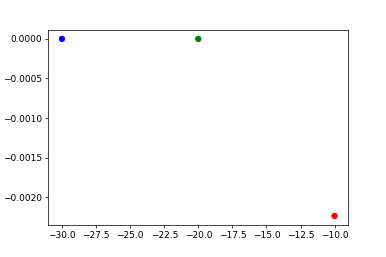

In [98]:
%matplotlib notebook
plt.figure()
plt.scatter([station_1_pos2[2][0], station_2_pos2[2][0], station_3_pos2[2][0]],[station_1_pos2[2][1], station_2_pos2[2][1], station_3_pos2[2][1]],c=['r', 'g', 'b'])

In [99]:
%matplotlib inline

tfu = importlib.reload(tfu)
# choose which line is right for each total station in this section (the correct position is the first or the 2nd found with the resection)
# for i in range(len(station_1_pos1)):
#     Tf1 = tfu.tf_from_pose_roll_pitch_yaw(station_1_pos1[i])
#     Tf12 = ttfu.tf_from_pose_roll_pitch_yaw(station_1_pos2[i])

#     Tf2 = tfu.tf_from_pose_roll_pitch_yaw(station_2_pos1[i])
#     Tf22 = ttfu.tf_from_pose_roll_pitch_yaw(station_2_pos2[i])

#     Tf3 = tfu.tf_from_pose_roll_pitch_yaw(station_3_pos1[i])
#     Tf32 = ttfu.tf_from_pose_roll_pitch_yaw(station_3_pos2[i])
#     print(Tf1)
#     print(Tf12)
#     print(Tf2)
#     print(Tf22)
#     print(Tf3)
#     print(Tf32)
TF1 = []
TF2 = []
TF3 = []
tp1 = []
tp2 = []
tp3 = []
TR1 = []
TR2 = []
TR3 = []

# for i in range(len(station_1_pos2)):
i = 2
TF1.append(tfu.tf_from_pose_roll_pitch_yaw(station_1_pos2[i]))
TF2.append(tfu.tf_from_pose_roll_pitch_yaw(station_2_pos2[i]))
TF3.append(tfu.tf_from_pose_roll_pitch_yaw(station_3_pos2[i]))
#print(TF1)
#print(TF2)
#print(TF3)
#print(trimble_1)
#print(trimble_2)
#print(trimble_3)
tp1.append(TF1[0]@trimble_1)
tp2.append(TF2[0]@trimble_2)
tp3.append(TF3[0]@trimble_3)
tp1[0] = tp1[0].T
tp2[0] = tp2[0].T
tp3[0] = tp3[0].T

#print(tp1)
#print(tp2)
#print(tp3)

TR1.append(calculate_tf_angle_using_scalar_product(tp1[0], liste_piliers, i))
TF1[0] = TF1[0]@TR1[0]
tp1[0] = TF1[0]@trimble_1
tp1[0] = tp1[0].T

TR2.append(calculate_tf_angle_using_scalar_product(tp2[0], liste_piliers, i))
TF2[0] = TF2[0]@TR2[0]
tp2[0] = TF2[0]@trimble_2
tp2[0] = tp2[0].T

TR3.append(calculate_tf_angle_using_scalar_product(tp3[0], liste_piliers, i))
TF3[0] = TF3[0]@TR3[0]
tp3[0] = TF3[0]@trimble_3
tp3[0] = tp3[0].T

[ 2.25891856e+01  3.30153529e+01 -8.20413959e-13]
[ 0 40  0]
0.6000447172895984
[[ 0.82531036 -0.56467938  0.          0.        ]
 [ 0.56467938  0.82531036  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[-3.59172247e-09  3.99999982e+01  0.00000000e+00]
[ 0 40  0]
0.0
[[ 1. -0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
[1.64082650e-08 3.99999969e+01 0.00000000e+00]
[ 0 40  0]
0.0
[[ 1. -0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


[0.003980893387760444, 0.003981310189159981, 6.673528018556871e-07, 0.003981076287484521, 0.003981462627995964, 6.357361395008266e-07]
[0.005210273503556433, 0.0052148397623630605, 4.6276940559738345e-06, 0.004381365405400374, 0.004384118094875782, 4.626811932465573e-06]
Median error for the control points:  3.981 mm
Median error for the validation points:  4.383 mm


<IPython.core.display.Javascript object>


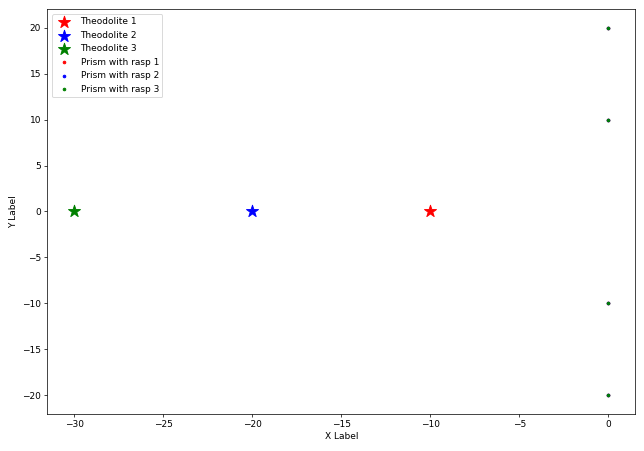

In [100]:
%matplotlib notebook

error_validation_points = []
error_control_points = []
# counter = 0
# for i,j,k in zip(tp1[0],tp2[0],tp3[0]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         #print("i: ", np.round(i, 2))
#         #print("j: ", np.round(j, 2))
#         #print("k: ", np.round(k, 2))
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter < 2:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

# counter = 0
# for i,j,k in zip(tp1[1],tp2[1],tp3[1]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==0 or counter==2:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1
error_12_x = []
error_12_y = []
error_12_z = []
error_13_x = []
error_13_y = []
error_13_z = []
error_23_x = []
error_23_y = []
error_23_z = []
error_1_x = []
error_1_y = []
error_1_z = []
error_2_x = []
error_2_y = []
error_2_z = []
error_3_x = []
error_3_y = []
error_3_z = []
counter = 0
for i,j,k in zip(tp1[0],tp2[0],tp3[0]):
        #print("i: ", i, "j: ", j, "k: ", k)
        dist_12 = np.linalg.norm(i-j)
        dist_13 = np.linalg.norm(i-k)
        dist_23 = np.linalg.norm(k-j)
        if counter==0 or counter==3:
            error_control_points.append(dist_12)
            error_control_points.append(dist_13)
            error_control_points.append(dist_23)
        else:
            error_validation_points.append(dist_12)
            error_validation_points.append(dist_13)
            error_validation_points.append(dist_23)
        error_12_x.append(i[0]-j[0])
        error_12_y.append(i[1]-j[1])
        error_12_z.append(i[2]-j[2])
        error_13_x.append(i[0]-k[0])
        error_13_y.append(i[1]-k[1])
        error_13_z.append(i[2]-k[2])
        error_23_x.append(j[0]-k[0])
        error_23_y.append(j[1]-k[1])
        error_23_z.append(j[2]-k[2])
        error_1_x.append(i[0]-liste_piliers[counter][0])
        error_1_y.append(i[1]-liste_piliers[counter][1])
        error_1_z.append(i[2]-liste_piliers[counter][2])
        error_2_x.append(j[0]-liste_piliers[counter][0])
        error_2_y.append(j[1]-liste_piliers[counter][1])
        error_2_z.append(j[2]-liste_piliers[counter][2])
        error_3_x.append(k[0]-liste_piliers[counter][0])
        error_3_y.append(k[1]-liste_piliers[counter][1])
        error_3_z.append(k[2]-liste_piliers[counter][2])
        counter += 1

# counter = 0
# for i,j,k in zip(tp1[3],tp2[3],tp3[3]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==1 or counter==2:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

# counter = 0
# for i,j,k in zip(tp1[4],tp2[4],tp3[4]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==1 or counter==3:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

# counter = 0
# for i,j,k in zip(tp1[5],tp2[5],tp3[5]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==2 or counter==3:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

print(error_control_points)
print(error_validation_points)
print("Median error for the control points: ", round(np.median(error_control_points)*1000, 3), "mm")
print("Median error for the validation points: ", round(np.median(error_validation_points)*1000, 3), "mm")
for i in range(len(TF1)):
    tfu.plot_trajectories_prism(3, tp1[i].T, tp2[i].T, tp3[i].T, TF1[i], TF2[i], TF3[i], 0, 0,"example.pdf",0)

[[ 1.95472830e+01  1.38997754e+01  2.60693038e+00 -3.03949199e+00]
 [ 1.08583282e+01  2.60693038e+00 -1.38997754e+01 -2.21531273e+01]
 [-4.58625145e-09 -2.90060022e-09 -2.90060022e-09 -4.58625145e-09]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]


<IPython.core.display.Javascript object>


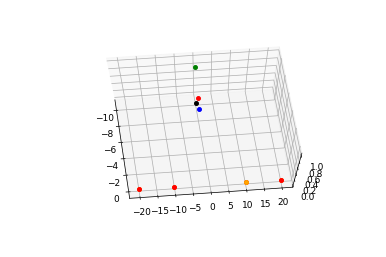

In [94]:
%matplotlib notebook
o1 = TF1@np.array([0,0,0,1])
x1 = TF1@np.array([1,0,0,1])
y1 = TF1@np.array([0,1,0,1])
z1 = TF1@np.array([0,0,1,1])
print(trimble_1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(o1[0][0],o1[0][1],o1[0][2], color='black')
ax.scatter(y1[0][0],y1[0][1],y1[0][2], color='r')
ax.scatter(z1[0][0],z1[0][1],z1[0][2], color='g')
ax.scatter(x1[0][0],x1[0][1],x1[0][2], color='b')

ax.scatter(tp1[0][0][0],tp1[0][0][1],tp1[0][0][2], color='r')
ax.scatter(tp1[0][1][0],tp1[0][1][1],tp1[0][1][2], color='r')
ax.scatter(tp1[0][2][0],tp1[0][2][1],tp1[0][2][2], color='r')
ax.scatter(tp1[0][3][0],tp1[0][3][1],tp1[0][3][2], color='r')

#ax.scatter(trimble_1.T[0][0],trimble_1.T[0][1],trimble_1.T[0][2], color='black')
#ax.scatter(trimble_1.T[1][0],trimble_1.T[1][1],trimble_1.T[1][2], color='r')
#ax.scatter(trimble_1.T[2][0],trimble_1.T[2][1],trimble_1.T[2][2], color='g')
#ax.scatter(trimble_1.T[3][0],trimble_1.T[3][1],trimble_1.T[3][2], color='b')

ax.scatter(pilier_A[0],pilier_A[1],pilier_A[2], color='orange')
ax.scatter(pilier_B[0],pilier_B[1],pilier_B[2], color='orange')
ax.scatter(pilier_C[0],pilier_C[1],pilier_C[2], color='orange')
ax.scatter(pilier_D[0],pilier_D[1],pilier_D[2], color='orange')




In [7]:
print(error_12_x)
print(error_12_y)
print(error_12_z)
print(error_13_x)
print(error_13_y)
print(error_13_z)
print(error_23_x)
print(error_23_y)
print(error_23_z)
trimble_1 = trimble_1.T
print(np.linalg.norm(tp1[0][0]-tp1[0][3])-548.578)
print(np.linalg.norm(trimble_1[0] - trimble_1[3])-548.578)
print(np.linalg.norm(liste_piliers[0]-liste_piliers[3])-548.578)
print(error_1_x)
print(error_1_y)
print(error_1_z)
print(error_2_x)
print(error_2_y)
print(error_2_z)
print(error_3_x)
print(error_3_y)
print(error_3_z)

[-0.010500715075822065, -0.00897048266227074, -0.010835463464092143, -0.007815710308810786]
[0.0023320217881632743, 0.003312423377167306, -0.004070898490510899, -0.0027526575747742754]
[-0.0019223103137926412, -0.002110442978847271, 0.002558292038661314, 0.0019223103137924191]
[0.09444292275177268, 0.0915986921897396, 0.09377017617314642, 0.09681453614837743]
[0.003441822160539232, 0.003112254032430428, -0.006549368788114407, -0.004030474176488497]
[-0.0005661944438941635, 5.6806047604385235e-05, -0.002123929120069201, 0.0005661944438943856]
[0.10494363782759475, 0.10056917485201033, 0.10460563963723857, 0.10463024645718821]
[0.0011098003723759575, -0.00020016934473687797, -0.002478470297603508, -0.0012778166017142212]
[0.0013561158698984777, 0.0021672490264516564, -0.004682221158730515, -0.0013561158698980336]
-0.01215442267130129
-0.012154422671414977
0.0
[0.13071166289779335, 0.12455201079555955, 0.13269159417289167, 0.13191273829368022]
[0.0057016962471720944, 0.003958797400144931,

In [ ]:
fig = plt.figure(figsize =(16, 6))
ax = fig.add_subplot(111)

box = ax.boxplot([error_control_points, error_validation_points], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2], ["Control points \n\n Median: "+str(round(np.median(error_control_points)*1000,2))+"mm \n Std: "+str(round(np.std(error_control_points)*1000,2))+"mm",
                          "Validation points \n\n Median: "+str(round(np.median(error_validation_points)*1000,2))+"mm \n Std: "+str(round(np.std(error_validation_points)*1000,2))+"mm"])
colors_box = ['#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error [m]")
plt.show()
#fig.savefig("./figs/new_resection_datasets_prior_only-f-2-1-1-1-6-1-L.jpg")

In [ ]:
for i in range(len(station_1_pos2)):
    print(station_1_pos2[i] - station_2_pos2[i])
    print(station_1_pos2[i] - station_3_pos2[i])
    print(station_2_pos2[i] - station_3_pos2[i])